In [1]:
# set up Spark
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()


#Access SparkContext from your SparkSession
print("APP Name :"+ spark.sparkContext.appName);
print("Master :"+ spark.sparkContext.master);

sqlContext = SQLContext(spark.sparkContext)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/27 19:49:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/27 19:49:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
APP Name :GenericAppName
Master :local[*]


/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


I tried using the augmented CSVs, but I couldn't succcessfully read it from Postgres after I wrote to it. The read command to more than 10 minutes and still wasn't able to produce a result. So, I decided to use the reduced dataset instead. I will run this on the cloud for the final submissions, so with the higher computation power, I should be able to analyze the augmented files.

In [2]:
# read in data
df_train = spark.read.csv('data_folder/train70_reduced.csv', header = True, inferSchema = True)
df_test = spark.read.csv('data_folder/test30_reduced.csv', header = True, inferSchema = True)

In [3]:
# add column to differentiate b/w train and test sets
from pyspark.sql.functions import col, lit

df_train_cat = df_train.withColumn("data_category", lit("train"))
df_test_cat = df_test.withColumn("data_category", lit("test"))

print('Train', df_train_cat.count())
print('Test', df_test_cat.count())


# combine dfs
df_combined = df_train_cat.union(df_test_cat)
print('Combined', df_combined.count())

Train 231646
Test 99290
Combined 330936


In [4]:
# write into postgresql db

db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="bigdata"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "mqtt"

# create df with train data 
df_combined.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", "bigdata")\
.option("Driver", db_properties['driver'])\
.save()

22/10/27 19:49:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
# read db to ensure data has been written in correctly
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", "bigdata")\
    .option("Driver", db_properties['driver'])\
    .load()

df_read.count()

330936

In [6]:
# average length of a MQTT message in train
df_train = df_read.filter(df_read['data_category'] == 'train')

print('Average length of a MQtt message in the training dataset is:',\
      df_train.agg({'`mqtt.len`':'mean'}).collect()[0][0])

Average length of a MQtt message in the training dataset is: 31.435725201384873


In [116]:
# average of length of TCP message grouped by target
df_read.groupby('`target`').agg({'`tcp.len`': 'mean'}).orderBy('`avg(tcp.len)`', ascending = False).show()

+----------+------------------+
|    target|      avg(tcp.len)|
+----------+------------------+
|     flood|13313.415986949429|
|       dos|312.65759830457716|
| malformed| 20.97491761259612|
|legitimate| 7.776101001432345|
|   slowite|3.9993479678330797|
|bruteforce|3.9871043376318873|
+----------+------------------+



In [28]:
# X most frequent TCP flags

def most_frequent(X):
    tcp_flags_count_df = df_read.groupby('`tcp.flags`').count().orderBy('count', ascending = False)
    flags_desc_list = tcp_flags_count_df.rdd.map(lambda x: x[0]).collect()
    return flags_desc_list[0:X]

['0x00000018', '0x00000010', '0x00000011']

In [65]:
# most popular target on Twitter

# get targets
targets = df_read.select('`target`').distinct().rdd.map(lambda x: x[0]).collect()

In [96]:
# set up KafkaConsumer to read tweets from Producer
from kafka import KafkaConsumer
import json
import time
import numpy as np


topic_name = 'project-twitter-streaming'

kafka_consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='latest',
    enable_auto_commit=True,
    auto_commit_interval_ms =  5000,
    fetch_max_bytes = 128,
    max_poll_records = 100,
    value_deserializer=lambda x: x.decode('utf-8'))

# create dictionary to keep track of count of search terms
counter_dict = dict(zip(targets, [0] * len(targets)))

for message in kafka_consumer:
    print(message.value)
    
    # split message
    split = message.value.lower().split()
    
    # count frequencies
    freq_df = spark.createDataFrame(split, "string").groupBy('value').count()\
    .orderBy('count', ascending = False)
    
    # extract count of search terms
    freqs = freq_dff.filter(freq_dff.value.isin(targets)).rdd.map(lambda x: [x[0],x[1]]).collect()
    
    # update count dict
    for freq in freqs:
        counter_dict[freq[0]] += freq[1]
    
    print(counter_dict)

Mi lugarcito feliz ? Mi hermano, dos segundos con el me puede cambiar el día ❤️‍🩹
{'slowite': 0, 'bruteforce': 0, 'flood': 1, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Hoy fui a mi nueva oficina a qué me entregaran material para ergonomía en home office, me tome dos tazas de café delicioso GRATIS y mi jefe me enseñó pacientemente unas fórmulas en excel… que sueño estoy viviendo 🥰
{'slowite': 0, 'bruteforce': 0, 'flood': 2, 'malformed': 0, 'dos': 0, 'legitimate': 0}
não gostam das políticas públicas que coloquem o pobre na faculdade, porque a faculdade só serve pra veicular “doutrina esquerdista”. não gostam dos auxílios que salvam o pobre da fome, porque aí é “mamar nas tetas do governo”. não gostam de dar esmola, nem de pagar imposto
{'slowite': 0, 'bruteforce': 0, 'flood': 3, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Tarcísio elogia todos os policiais de São Paulo como uma grande polícia
Fala de aumentar a assistencia e cuidar da saúde mental dos polícias
Acredita na valorização
MA

{'slowite': 0, 'bruteforce': 0, 'flood': 36, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Que ódio desses fedorentos desse Jorginho asqueroso vai se foder embuste dos infernos
{'slowite': 0, 'bruteforce': 0, 'flood': 37, 'malformed': 0, 'dos': 0, 'legitimate': 0}
❤️ até quando vai durar o coraçãozinho por aqui…aguardando cenas dos próximos capítulos
{'slowite': 0, 'bruteforce': 0, 'flood': 38, 'malformed': 0, 'dos': 0, 'legitimate': 0}
tava relendo a cena da reunião dos grão-senhores e pqp, é de longe umas das minhas parte favoritas de acowar 

treta e caos do jeito que o povo gosta
{'slowite': 0, 'bruteforce': 0, 'flood': 39, 'malformed': 0, 'dos': 0, 'legitimate': 0}
estoy completamente enamorada de los dos cordobeses
{'slowite': 0, 'bruteforce': 0, 'flood': 40, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Nada más a mi me pasa que hago la transferencia zelle justo cuando a @quikpago le da por anotar la cuenta mal en la app, se tarden dos horas y media en darme razón y de paso tengo que 

EU CANTEI CAMISA 10 OLHANDO PRA ELA KRLLLLLL
FOI UM DOS MELHORES MOMENTOS DA NOITE!!!!!!!!!!!!
{'slowite': 0, 'bruteforce': 0, 'flood': 77, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Necesito verlos a mis amigos por más que me hagan bullying cada dos palabras que digo
{'slowite': 0, 'bruteforce': 0, 'flood': 78, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Eu to meio perdido, estou assistindo o debate na globo para governo estadual de pernambuco ou presidencial?
Pq Marilia só consegue falar de Bolsonaro e Lula. 
Raquel consegue debater sem citar o nome de nenhum dos dois.
{'slowite': 0, 'bruteforce': 0, 'flood': 79, 'malformed': 0, 'dos': 0, 'legitimate': 0}
ATENÇÃO TRABALHADOR Economistas do LULA vão cobrar impostos  e encargos sociais dos informais e micro empeenderores individuais por meio do Pix. PENSE SEU VOTO!
{'slowite': 0, 'bruteforce': 0, 'flood': 80, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Solo dos graficas mas
{'slowite': 0, 'bruteforce': 0, 'flood': 81, 'malformed': 0, 'do

{'slowite': 0, 'bruteforce': 0, 'flood': 117, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Marxista: aquele que usa a riqueza do pai (eventualmente a riqueza do Estado) para destruir a riqueza dos outros
{'slowite': 0, 'bruteforce': 0, 'flood': 118, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Felicidades Sav y equipo de ACS por haber ganado no uno ni dos, si no 8 PREMIOS en “The Wild Bunch Film Festival”

PREMIOS SAV:
Best Actress (Modern Day Feature Western): Savannah Lee May
￼
Best Score/Song (Modern Day Western Feature Film): "Hailey's Comet” Pby Savannah Lee May https://t.co/4H87bc4qix
{'slowite': 0, 'bruteforce': 0, 'flood': 119, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Eu quero ouvir a voz dos professores de Caruaru? É verdade mesmo que Caruaru é esse paraíso?
{'slowite': 0, 'bruteforce': 0, 'flood': 120, 'malformed': 0, 'dos': 0, 'legitimate': 0}
dios mora ahí re que le clavo dos votos a nacho LA ODIO
{'slowite': 0, 'bruteforce': 0, 'flood': 121, 'malformed': 0, 'dos': 0, 'legiti

{'slowite': 0, 'bruteforce': 0, 'flood': 157, 'malformed': 0, 'dos': 0, 'legitimate': 0}
meu destino realmente é ficar sozinha pelo resto da minha vida, nunca casar, nunca ter filhos, estudar até o fim dos tempos pra me aposentar e morrer
{'slowite': 0, 'bruteforce': 0, 'flood': 158, 'malformed': 0, 'dos': 0, 'legitimate': 0}
tá explicado o motivo dos 10 min kkkkk
{'slowite': 0, 'bruteforce': 0, 'flood': 159, 'malformed': 0, 'dos': 0, 'legitimate': 0}
“Pseudo cientista” AHHHH NÃO GENTE!!! Falar do Pedrinho, aí é demais @PedroHallal. O cara é só um dos mais influentes cientistas do MUNDO!!!!
{'slowite': 0, 'bruteforce': 0, 'flood': 160, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Toda vez que alguém fala que a larissa é animer ele está cheirando dez carreiras de suco tang sabor uva com 3 sugar daddys em um dos circulos do inferno 😂😂😂
{'slowite': 0, 'bruteforce': 0, 'flood': 161, 'malformed': 0, 'dos': 0, 'legitimate': 0}
O Vasco vai subir.

60% pela torcida, 40% porque a concorrência é f

{'slowite': 0, 'bruteforce': 0, 'flood': 194, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Charles Darwin vió un buitre y una paloma y dijo: "uy, como se parecen, los dos tienen plumas" y la gente le aplaudía las gracias y claro...
{'slowite': 0, 'bruteforce': 0, 'flood': 195, 'malformed': 0, 'dos': 0, 'legitimate': 0}
É literalmente impossível não acompanhar futebol onde eu moro a vizinhança me avisa de cada gol q acontece dos 4 cariocas
{'slowite': 0, 'bruteforce': 0, 'flood': 196, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Solo quiero dormir dos días seguidos
{'slowite': 0, 'bruteforce': 0, 'flood': 197, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Se você quer me conhecer venha diretamente a mim. Não tire conclusões ao meu respeito baseando-se nas opiniões de quem está ao meu redor. Eu posso ser o melhor dos seus sonhos ou o pior dos seus pesadelos. Só depende de vocÊ.
{'slowite': 0, 'bruteforce': 0, 'flood': 198, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Yo diciendo dos cositas en fr

Quando um dos maiores jornais do mundo manifesta voto a favor de um candidato, mas os periódicos do seu país falam em "escolhas difíceis": 🤡
{'slowite': 0, 'bruteforce': 0, 'flood': 236, 'malformed': 0, 'dos': 0, 'legitimate': 0}
2 a 2 aos 52 minutos dos segundo tempo, jogo vai até os 55. HAJA CORAÇÃO!!!!
{'slowite': 0, 'bruteforce': 0, 'flood': 237, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Galisteu desesperada pq sabe que vai perder um dos fav dela, passada!
{'slowite': 0, 'bruteforce': 0, 'flood': 238, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Sábadito cachondo tardecita especial tarde de diablitas HALLOWEEN🎃S3X×XUAL con cuatro lindas muñecas para ti diversión garantizada🎉participación ilimitada💦coope super accesible bebidas🥃sin costo te esperamos CDMX a dos pasos de metro salto del agua línea verde 5564720698 🔄♥️ https://t.co/vM3ajjFVEG
{'slowite': 0, 'bruteforce': 0, 'flood': 239, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Assistindo The Kardashians pra me alienar com algo que n

{'slowite': 0, 'bruteforce': 0, 'flood': 273, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Fica a dica presidente. É só falar dos amigos do 9 dedos. Ele se perde todo. Insista nisso, já que tem bloco para tema livre.
{'slowite': 0, 'bruteforce': 0, 'flood': 274, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Faz o Pix dos 10 minutos Vasco da grana
{'slowite': 0, 'bruteforce': 0, 'flood': 275, 'malformed': 0, 'dos': 0, 'legitimate': 0}
quem vê não acredita que a uns anos atrás eu assistia os vídeos do youtube e sonhando em um dia ter uma barca igual a dos vídeos, hoje em dia eu consegui e realizei, o projeto do tutuba vai vir diferenciado demais. 🦈❤️
{'slowite': 0, 'bruteforce': 0, 'flood': 276, 'malformed': 0, 'dos': 0, 'legitimate': 0}
não me arrependo dos meus erros, porquê através deles aprendi muita coisa, só agradecer boa noite com Jesus 🙏🥰🤍... https://t.co/tywD5uZdhs
{'slowite': 0, 'bruteforce': 0, 'flood': 277, 'malformed': 0, 'dos': 0, 'legitimate': 0}
A veces es muy loco cuándo para

debo 5 trabajos d arte y sin embargo sigo durmiendo dos horas de siesta todos los días https://t.co/UCLLjGawSq
{'slowite': 0, 'bruteforce': 0, 'flood': 314, 'malformed': 0, 'dos': 0, 'legitimate': 0}
tomei banho
passei perfuminho
vesti minha roupa confortável de mendigo

estou pronto pra deitar na cama e

ficar lembrando dos erros do passado
ficar criando situações q nunca vão acontecer
esperando as paranóias acabarem com o resto de psicológico que ainda me resta
{'slowite': 0, 'bruteforce': 0, 'flood': 315, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Qué retroputiza le están acomodando al Toluca. Uno esperaba que Pachuca ganara, pero después de jugar los dos partidos, no a la mitad del primero.
{'slowite': 0, 'bruteforce': 0, 'flood': 316, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Dos besitos xq tres mucha plata 🤙
{'slowite': 0, 'bruteforce': 0, 'flood': 317, 'malformed': 0, 'dos': 0, 'legitimate': 0}
📣 New Podcast! "Simón y Judas (28-10-22)" on @Spreaker #alguno #ama #conozcan #cumpl

{'slowite': 0, 'bruteforce': 0, 'flood': 352, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Me encantaria irme a dormir despues de tomarme un vinito o un gin tonic, y tener un amorcito e ir directo a la cama a mimir en pedo los dos para mas placerrrrr
{'slowite': 0, 'bruteforce': 0, 'flood': 353, 'malformed': 0, 'dos': 0, 'legitimate': 0}
MLB continues Flood Warning for St Johns River near Astor [FL] until further notice https://t.co/PHYvnbqCxQ https://t.co/7VqdNg8F8N
{'slowite': 0, 'bruteforce': 0, 'flood': 354, 'malformed': 0, 'dos': 0, 'legitimate': 0}
MLB continues Flood Warning for St Johns River near Astor [FL] until further notice https://t.co/PmKKGII8Na https://t.co/gknmFqQnXz
{'slowite': 0, 'bruteforce': 0, 'flood': 355, 'malformed': 0, 'dos': 0, 'legitimate': 0}
MLB continues Flood Warning for St Johns River near Astor [FL] until further notice https://t.co/L735DNbfWR https://t.co/Hgyliuq32r
{'slowite': 0, 'bruteforce': 0, 'flood': 356, 'malformed': 0, 'dos': 0, 'legitimate': 0}

{'slowite': 0, 'bruteforce': 0, 'flood': 393, 'malformed': 0, 'dos': 0, 'legitimate': 0}
amo a amizade dos meninos sortuda dms
{'slowite': 0, 'bruteforce': 0, 'flood': 394, 'malformed': 0, 'dos': 0, 'legitimate': 0}
cara eu namoro o homem dos meus sonhos fodase
{'slowite': 0, 'bruteforce': 0, 'flood': 395, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Cumpliendo sueño de ser profesora de las dos cosas que más amo en la vida 🥰😍
{'slowite': 0, 'bruteforce': 0, 'flood': 396, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Je connais des gens qui disent qu'ils sont honnêtes mais ils ne le sont pas, ils prétendent devant moi qu'ils sont pratiquement des saints et derrière mon dos ils sont pareils au diable, ils souhaitent la mort même pour ceux qui paient le salaire, si ce n'était pas Sans nous tu+
{'slowite': 0, 'bruteforce': 0, 'flood': 397, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Julieta y Daniela en la casa son literalmente estas dos:
#GH22 #GranHermano #Gh2022 https://t.co/zWgywwbZK7
{'slow

@sampaiocorrea pode ligar pra polícia pq roubaram vcs bonito nesse estádio dos ratos kkkkkkk
{'slowite': 0, 'bruteforce': 0, 'flood': 430, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Governo propõe rescisão dos contratos das usinas do leilão emergencial de energia https://t.co/YyHi8v7Gjx https://t.co/B97Q1ahkW5
{'slowite': 0, 'bruteforce': 0, 'flood': 431, 'malformed': 0, 'dos': 0, 'legitimate': 0}
eu queria ter o poderzinho dos deuses de tgcf e mudar meu corpo e gênero o tempo todo puts será q eu sou um deus preso em forma de humano
{'slowite': 0, 'bruteforce': 0, 'flood': 432, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Pinche Daddy Yankee quien te crees, llevo esperando más de dos horas. Ni que fueras Michael Jackson
{'slowite': 0, 'bruteforce': 0, 'flood': 433, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Dos três candidatos de direita que tinha no 1° turno da eleição do RS, infelizmente acabou indo o mais desqualificado possível. 

O cara tá queimando totalmente o filme contra o péssi

{'slowite': 0, 'bruteforce': 0, 'flood': 467, 'malformed': 0, 'dos': 0, 'legitimate': 0}
How I feel every time I come on here and say “Josh Hawley is hot” and the liberals flood my replies https://t.co/Djs8YysjrY
{'slowite': 0, 'bruteforce': 0, 'flood': 468, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Gol dos cara KKKKKKKKKKKKKKKKKKK
{'slowite': 0, 'bruteforce': 0, 'flood': 469, 'malformed': 0, 'dos': 0, 'legitimate': 0}
¿Como que 6 meses con tu novia? Si hace dos me andabas jurando amor eterno jaja
{'slowite': 0, 'bruteforce': 0, 'flood': 470, 'malformed': 0, 'dos': 0, 'legitimate': 0}
DENUNCIA NA TV PUC GOIÁS SOBRE CERCEAMENTO DO DIREITO E DO ACESSO A JUSTIÇA PRATICADO PELO JUDICIÁRIO GOIANO EM MEU DESFAVOR.

INÚMERAS PROVAS DE INFRAÇÕES DISCIPLINARES DOS MAGISTRADOS QUE PASSARAM PELO CASO, TAIS MAGISTRADOS CERCEANDO GARANTIAS CONSTITUCIONAIS. https://t.co/6KgvtVzcvm
{'slowite': 0, 'bruteforce': 0, 'flood': 471, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Gol dos caras
{'slowite': 0, '

{'slowite': 0, 'bruteforce': 0, 'flood': 503, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Are you currently battling to generate enough clients to check your legitimate home business,  Read this strategy https://t.co/IZUUNbnC5b https://t.co/Ka0q91ygBl
{'slowite': 0, 'bruteforce': 0, 'flood': 504, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Tenho pena dos vascaíno 🤣🤣
{'slowite': 0, 'bruteforce': 0, 'flood': 505, 'malformed': 0, 'dos': 0, 'legitimate': 0}
o fato de que foi durante a pandemia que eu tive alguns dos pontos mais altos da minha vida é preocupante
{'slowite': 0, 'bruteforce': 0, 'flood': 506, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Nosotros en dos semanas cuando no tengamos de que hablar #gh22 #granhermano #gh2022 https://t.co/bexGococpn
{'slowite': 0, 'bruteforce': 0, 'flood': 507, 'malformed': 0, 'dos': 0, 'legitimate': 0}
@gillianwhore  Com base no seu perfil você é: 90% ligado nos lançamentos + 10% louco para estar por dentro dos programas que os outros comentam! = 100% 

{'slowite': 0, 'bruteforce': 0, 'flood': 547, 'malformed': 0, 'dos': 0, 'legitimate': 0}
El país en llamas, una catástrofe, cada día veo más "cenizas" y solo escucho, Las paso si o no, Larroque criticando al presidentito, Mínimo kirschner haciéndose el estadista, el "gato" con discurso de un fracasado, panqueque Maza el Ministro de economía donde 2 más dos le dan 5. https://t.co/ret4gNa8uJ
{'slowite': 0, 'bruteforce': 0, 'flood': 548, 'malformed': 0, 'dos': 0, 'legitimate': 0}
As pessoas esquecem que por trás dos órgãos da justiça, trabalha pessoas de carne e osso e não robô, pra sair disseminando ódio só pq estamos SIMPLESMENTE fazendo o nosso trabalho
{'slowite': 0, 'bruteforce': 0, 'flood': 549, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Y con los años todavía me duele recordar a mis dos🐶🐶,sentimientos a flor de piel...😔🐕🌈💔
{'slowite': 0, 'bruteforce': 0, 'flood': 550, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Vascaíno sofre mane KKKKKKKKK coitado dos cara
{'slowite': 0, 'bruteforc

{'slowite': 0, 'bruteforce': 0, 'flood': 586, 'malformed': 0, 'dos': 0, 'legitimate': 0}
GOL DOS CARAS HUIOSADFHIUDHASUIDHASUIDHASUIDHUIASHDUIASHDUIASD
{'slowite': 0, 'bruteforce': 0, 'flood': 587, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Rubius y Auron bueno que se puede esperar de esos jaaj auron siempre diciendo lo que se le canta el ort pero RUBIUS a ese no lo paso me da asco hasta nauseas ahora laguien morira si esos dos weones no van a mexico NADIE https://t.co/cGQ5pI91j3
{'slowite': 0, 'bruteforce': 0, 'flood': 588, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Dá pena dos vascainos 🤣🤣🤣
{'slowite': 0, 'bruteforce': 0, 'flood': 589, 'malformed': 0, 'dos': 0, 'legitimate': 0}
haddad merece 100% dos votos domingo
{'slowite': 0, 'bruteforce': 0, 'flood': 590, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Durante o governo do Felicio Ramuth aqui em são josé dos campos (atual vice do Tarcísio) eu estava fora da cidade. Queria muito que alguém me dissesse coisas boas que ele fez pra SJC al

{'slowite': 0, 'bruteforce': 0, 'flood': 627, 'malformed': 0, 'dos': 0, 'legitimate': 0}
sim me identifiquei muito em Pearl agora e trabalho dos meus amigos em me deixar o mais longe possível da área rural do rio grande do sul
{'slowite': 0, 'bruteforce': 0, 'flood': 628, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Amar a dos no resulta, por muy sabroso que sea
{'slowite': 0, 'bruteforce': 0, 'flood': 629, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Regime dos terroristas!!!! Dilma , mariguela!!! https://t.co/qJiuvsWnQf
{'slowite': 0, 'bruteforce': 0, 'flood': 630, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Gosto mto de ver jogos da Série B, ainda mais dos ditos "grandes", é sempre certeza de um bom entretenimento
{'slowite': 0, 'bruteforce': 0, 'flood': 631, 'malformed': 0, 'dos': 0, 'legitimate': 0}
LKKKKKKKKKKKKKKK GOL DOS XARAS
{'slowite': 0, 'bruteforce': 0, 'flood': 632, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Se eu parei de lhe seguir no insta, vá lá e pare de me seguir de volt

{'slowite': 0, 'bruteforce': 0, 'flood': 671, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Isso vai além de ruindade e limitação técnica.

É MALDIÇÃO. Esse clube é AMALDIÇOADO.

Nem o mais cruel dos roteiristas escreveria algo assim... mas com o Vasco acontece.

VAI TOMAR NOC U!!!!!!
{'slowite': 0, 'bruteforce': 0, 'flood': 672, 'malformed': 0, 'dos': 0, 'legitimate': 0}
kkkkkkkkkk vasco dos infernos
{'slowite': 0, 'bruteforce': 0, 'flood': 673, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Ituano tem que ganhar do Londrina pra fazer contra o Vasco um dos jogos do ano semana que vem em Itu
{'slowite': 0, 'bruteforce': 0, 'flood': 674, 'malformed': 0, 'dos': 0, 'legitimate': 0}
sinto falta dos momentos ou da pessoa? tiktok me colocando pra pensar a essa hora
{'slowite': 0, 'bruteforce': 0, 'flood': 675, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Alguém me explica pq o Kanye West tá sendo banido dos lugar
{'slowite': 0, 'bruteforce': 0, 'flood': 676, 'malformed': 0, 'dos': 0, 'legitimate': 0}

{'slowite': 0, 'bruteforce': 0, 'flood': 714, 'malformed': 0, 'dos': 0, 'legitimate': 0}
De coração, eu sinto muita pena dos vascaínos
{'slowite': 0, 'bruteforce': 0, 'flood': 715, 'malformed': 0, 'dos': 0, 'legitimate': 0}
agora o coursera separa os cursos em módulos de forma que só dá pra pedir auxílio financeiro em um dos módulos por vez e nao posso mais dar um copia e cola em varios auxilios de cursos variados que eu nem vou fazer. absurdo
{'slowite': 0, 'bruteforce': 0, 'flood': 716, 'malformed': 0, 'dos': 0, 'legitimate': 0}
🍁 Dos sistemas agrícolas españoles se convierten en Patrimonio Agrícola Mundial... https://t.co/CBBG5rKsa1
{'slowite': 0, 'bruteforce': 0, 'flood': 717, 'malformed': 0, 'dos': 0, 'legitimate': 0}
Ahhhhhhhh Haddad, volta pra sala de aula. Aproveita o aumento de 33% dos professores, melhor rsrs.
{'slowite': 0, 'bruteforce': 0, 'flood': 718, 'malformed': 0, 'dos': 0, 'legitimate': 0}
O que mais me surpreende no Marvel SNAP é que o jogo passou por beta fechado e 

KeyboardInterrupt: 

<AxesSubplot:>

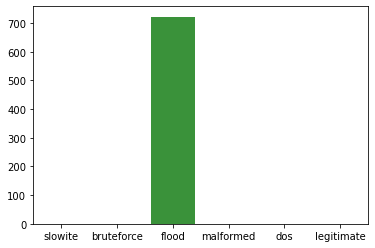

In [105]:
# after stream is over, plot frequencies
import seaborn as sns

sns.barplot(list(counter_dict.keys()), list(counter_dict.values()))

In [117]:
# split dict in keys and vals
keys = list(counter_dict.keys())
vals = list(counter_dict.values())

# find key with highest val
print('Most popular attack on Twitter is:', keys[vals.index(max(vals))])

Most popular attack on Twitter is: flood
